In [1]:
import sys
sys.path.insert(0,'/global/homes/i/ihasan/python_stuff/lib/python3.7/site-packages/')

In [2]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import dustmaps
from dustmaps.sfd import SFDQuery
from astropy.coordinates import SkyCoord
from dustmaps.config import config
sys.path.insert(0,'/global/homes/i/ihasan/python_stuff/lib/python3.7/site-packages/')
from pzblend import PhotozBlend
#sys.path.insert(0,"/global/cfs/cdirs/lsst/groups/PZ/PhotoZDC2/run2.2i_dr6_test/gcr-catalogs/lib/python3.7/site-packages/GCRCatalogs-0.18.1-py3.7.egg")
#sys.path.insert(0,'/global/homes/i/ihasan/python_stuff/lib/python3.7/site-packages/')
import GCRCatalogs
from GCR import GCRQuery

In [15]:
# plotting parameters to make font big
plt.rc('axes', labelsize=25)
plt.rc('xtick',labelsize=25)
plt.rc('ytick',labelsize=25)
plt.rcParams['xtick.minor.visible'] = True

In [3]:
object_cat = GCRCatalogs.load_catalog('dc2_object_run2.2i_dr6a_with_photoz')

/global/common/software/lsst/common/miniconda/py3.7-4.7.12.1-v2/envs/desc/lib/python3.7/site-packages/GCRCatalogs/register.py:395: UserWarning: `dc2_object_run2.2i_dr6a` has been deprecated and may be removed in the future.
Use dc2_object_run2.2i_dr6
If your analysis requires this specific catalog, please open an issue at https://github.com/LSSTDESC/gcr-catalogs/issues
  f"`{self.rootname}` has been deprecated and may be removed in the future.\n{deprecation_msg}"


In [4]:
tract_ids = [2731, 2904, 2906, 3081, 3082, 3084, 3262, 3263,
             3265, 3448, 3450, 3831, 3832, 3834, 4029, 4030,
             4031, 2905, 3083, 3264, 3449, 3833]

In [5]:
basic_cuts = [
    GCRQuery('extendedness > 0'),     # Extended objects
    GCRQuery((np.isfinite, 'mag_i')), # Select objects that have i-band magnitudes
    GCRQuery('clean'), # The source has no flagged pixels (interpolated, saturated, edge, clipped...)
                       # and was not skipped by the deblender
    GCRQuery('xy_flag == 0'), # Bad centroiding
    GCRQuery('snr_i_cModel >= 10'),
    GCRQuery('detect_isPrimary'), # (from this and below) basic flag cuts
    ~GCRQuery('deblend_skipped'),
    ~GCRQuery('base_PixelFlags_flag_edge'),
    ~GCRQuery('base_PixelFlags_flag_interpolatedCenter'),
    ~GCRQuery('base_PixelFlags_flag_saturatedCenter'),
    ~GCRQuery('base_PixelFlags_flag_crCenter'),
    ~GCRQuery('base_PixelFlags_flag_bad'),
    ~GCRQuery('base_PixelFlags_flag_suspectCenter'),
    ~GCRQuery('base_PixelFlags_flag_clipped')
]

mag_filters = [
    (np.isfinite, 'mag_i'),
    'mag_i < 25.',
]

object_df_list = []
for i in tract_ids:
    object_data = object_cat.get_quantities(['ra','dec','objectId', 'mag_i_cModel', 'magerr_i_cModel',
                                      'mag_r_cModel', 'magerr_r_cModel',
                                             'mag_g_cModel', 'magerr_g_cModel','z_mode','photoz_pdf'],
                                      filters=basic_cuts+mag_filters, native_filters=['tract == {}'.format(i)])
    object_df_list.append(pd.DataFrame(object_data))
coadd_df = pd.concat(object_df_list)

/global/common/software/lsst/common/miniconda/py3.7-4.7.12.1-v2/envs/desc/lib/python3.7/site-packages/GCRCatalogs/dc2_dm_catalog.py:43: RuntimeWarning: invalid value encountered in log10
  return -2.5 * np.log10(flux) + AB_mag_zp_wrt_nanoJansky
/global/common/software/lsst/common/miniconda/py3.7-4.7.12.1-v2/envs/desc/lib/python3.7/site-packages/GCRCatalogs/dc2_dm_catalog.py:43: RuntimeWarning: divide by zero encountered in log10
  return -2.5 * np.log10(flux) + AB_mag_zp_wrt_nanoJansky


In [6]:
band_a_ebv = np.array([4.81,3.64,2.70,2.06,1.58,1.31])
coords = c = SkyCoord(coadd_df['ra'], coadd_df['dec'], unit = 'deg',frame='fk5')
sfd = SFDQuery()
ebvvec = sfd(coords)
coadd_df['ebv'] = ebvvec
coadd_df['mag_i_lsst'] = coadd_df['mag_i_cModel'] - coadd_df['ebv']*band_a_ebv[3]

truth_cat = GCRCatalogs.load_catalog('cosmoDC2_v1.1.4_small')

truth_data = truth_cat.get_quantities(['ra', 'dec', 'galaxy_id','halo_id', 'redshift','mag_i', 'mag_i_lsst',
                                       'mag_g', 'mag_r'],filters=['mag_i_lsst < 28.','dec < -38.5'])
truth_df = pd.DataFrame(truth_data)

In [7]:
zgrid_filename = 'data/zgrid.npy'
zgrid = np.load(zgrid_filename)

pzb = PhotozBlend(truth_df, coadd_df, zgrid)
pzb.fof_match(verify=True, plot=False, load_cached=True, filename='output/bpz_fof_1.0.cache') #save_cached=True

<module>:fof_match: FoF results are verified, everything looks good.


In [8]:
# to make zz plots we need point estimates and the true redshift information
# we can use the filtering stuff Erfan set up to grab this data. Get the 2-1 case truthpick bright
# this takes a while to run
i_truth_bright_21, redshift_bright_21 = pzb.filter('truth', 2, 1, where={'mag_i_lsst': 'min'}).get('mag_i_lsst','redshift')

INFO:root:get:translate_easy_string: Evaluating ['mag_i_lsst', 'redshift'] in the truth catalog after filtering has already been done
INFO:root:<module>:get: Columns accessible for the 2 evaluations: ['mag_i_lsst', 'redshift', 'mag_i', 'galaxy_id', 'mag_r', 'halo_id', 'mag_g', 'ra', 'dec', 'group_id']


✓ Done!


In [9]:
# get the 2-1 case truthpick faint.
# this takes a while to run
i_truth_faint_21, redshift_faint_21 = pzb.filter('truth', 2, 1, where={'mag_i_lsst': 'max'}).get('mag_i_lsst','redshift')

In [10]:
coadd_df.columns

Index(['z_mode', 'magerr_r_cModel', 'mag_g_cModel', 'mag_i_cModel',
       'magerr_g_cModel', 'objectId', 'photoz_pdf', 'mag_r_cModel',
       'magerr_i_cModel', 'ra', 'dec', 'ebv', 'mag_i_lsst'],
      dtype='object')

In [11]:
# get the observed coadd information for the 2-1 case
i_coadd_21, z_mode_21 = pzb.filter('coadd', 2, 1).get('mag_i_cModel','z_mode')

In [12]:
# truth information for the 1-1 case
i_truth_bright_11, redshift_bright_11 = pzb.filter('truth', 1, 1, where={'mag_i_lsst': 'min'}).get('mag_i_lsst','redshift')

INFO:root:get:translate_easy_string: Evaluating ['mag_i_lsst', 'redshift'] in the truth catalog after filtering has already been done
INFO:root:<module>:get: Columns accessible for the 2 evaluations: ['mag_i_lsst', 'redshift', 'mag_i', 'galaxy_id', 'mag_r', 'halo_id', 'mag_g', 'ra', 'dec', 'group_id']


✓ Done!


In [13]:
# get the observed coadd information for the 1-1 case
i_coadd_11, z_mode_11 = pzb.filter('coadd', 1, 1).get('mag_i_cModel','z_mode')

In [14]:
# this creates dmag1, boolean mask to give you 2-1 galaxies that are 1 mag apart or less
dmag1 = i_truth_faint_21 - i_truth_bright_21 < 1

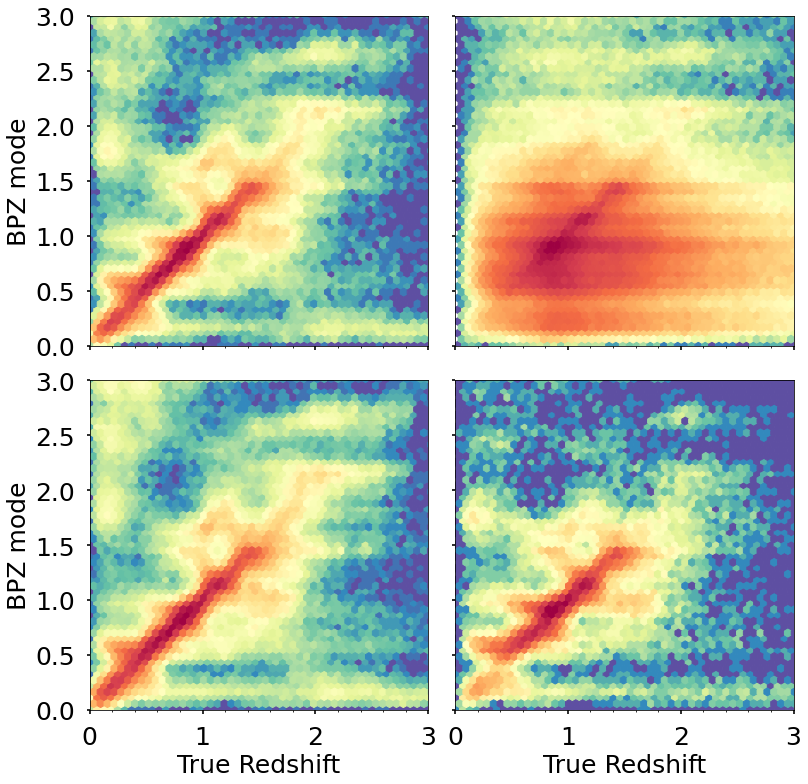

In [17]:
colorbar='horizontal' 
pad='1.3%'
cmap=plt.cm.Spectral_r
annotate=True

fig, ax = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(11,11))
im00 = ax[0,0].hexbin(redshift_bright_21, z_mode_21, gridsize=50, bins='log', cmap=cmap)
im01 = ax[0,1].hexbin(redshift_faint_21, z_mode_21, gridsize=50, bins='log', cmap=cmap)
im10 = ax[1,0].hexbin(redshift_bright_11, z_mode_11, gridsize=50, bins='log',cmap=cmap)
im11 = ax[1,1].hexbin(redshift_bright_21[dmag1], z_mode_21[dmag1], gridsize=50, bins='log', cmap=cmap)
#im11 = ax[1,1].axis('off')

for a in ax.flatten():
    a.set_xlim([0,3])
    a.set_ylim([0,3])


ax[1,0].set_xlabel('True Redshift')
ax[0,0].set_ylabel('BPZ mode')
ax[1,0].set_ylabel('BPZ mode')
ax[1,1].set_xlabel("True Redshift")
plt.tight_layout()
plt.savefig('output/bpz-zz.pdf', dpi=300, bbox_inches = "tight")

## Point Statistics and other plots

## 1-1 case

In [18]:
pzb.calc_point_statistics(num_truth=1, num_coadd=1, pz_type='z_mode')

INFO:root:calc_point_statistics:load_redshifts: New redshift dataframes have been created.


(0.04463093566766273, 0.00620151315419858, 0.08560912493254867)

INFO:root:plot_pdf:load_redshifts: The redshift dataframes remained unchanged since no update was needed.
INFO:root:plot_pdf:stack_photoz: New stacked photoz's have been created.
INFO:root:plot_pdf:kde_dask: Estimated the bandwidth of the kernel using the scott method to be 0.024.


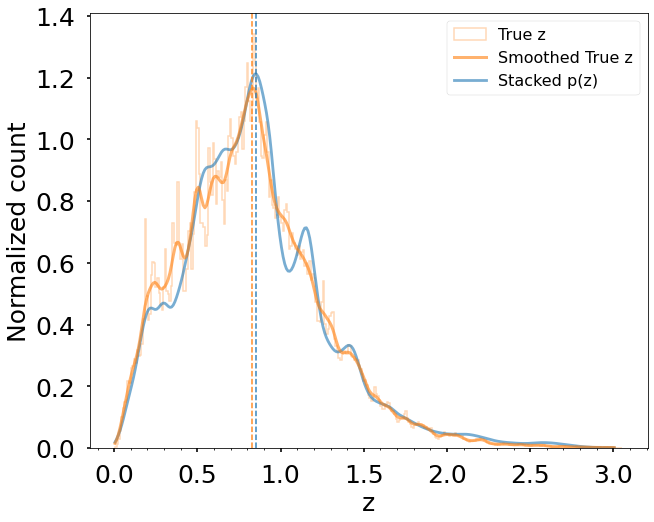

In [19]:
pzb.plot_pdf(num_truth=1, num_coadd=1, pz_type='z_mode')

In [20]:
pzb.KS_PDF()

INFO:root:KS_PDF:load_redshifts: The redshift dataframes remained unchanged since no update was needed.
INFO:root:KS_PDF:stack_photoz: The stacked photoz remained unchanged since no update was needed.


0.025312276817243295

INFO:root:plot_pit:load_redshifts: The redshift dataframes remained unchanged since no update was needed.


INFO:root:plot_pit:calc_pits: New PIT values have been created.


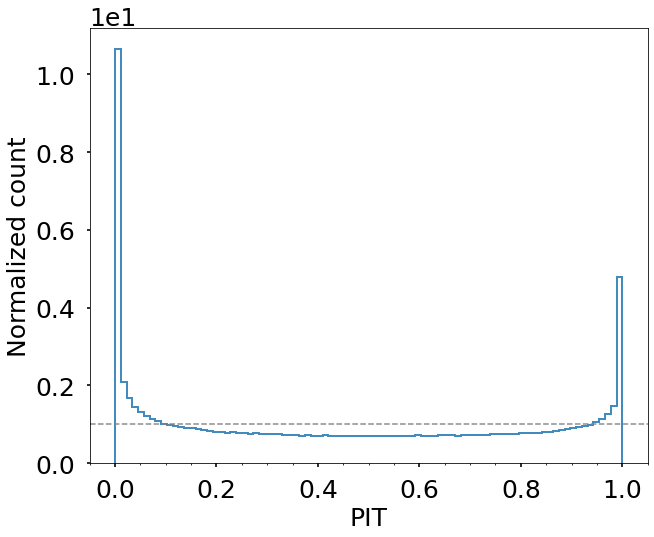

In [21]:
pzb.plot_pit()

In [22]:
pzb.KS_PITS(num_truth=1, num_coadd=1, pz_type='z_mode')

INFO:root:KS_PITS:load_redshifts: The redshift dataframes remained unchanged since no update was needed.
INFO:root:KS_PITS:calc_pits: The PIT values remained unchanged since no update was needed.


KstestResult(statistic=0.1433958571697153, pvalue=0.0)

In [23]:
pzb.calc_cde_loss()

-0.0885663558728993

In [24]:
pzb.calc_3_moments()

{'first': 0.85099125, 'second': 0.9119871, 'third': 1.1706421}

## 2-1 case

In [25]:
pzb.calc_point_statistics(num_truth=2, num_coadd=1, pz_type='z_mode', truth_pick='bright')

INFO:root:calc_point_statistics:load_redshifts: New redshift dataframes have been created.


(0.05147961913479413, 0.007815229629540978, 0.12018025440160227)

INFO:root:plot_pdf:load_redshifts: The redshift dataframes remained unchanged since no update was needed.
INFO:root:plot_pdf:stack_photoz: New stacked photoz's have been created.
INFO:root:plot_pdf:kde_dask: Estimated the bandwidth of the kernel using the scott method to be 0.031.


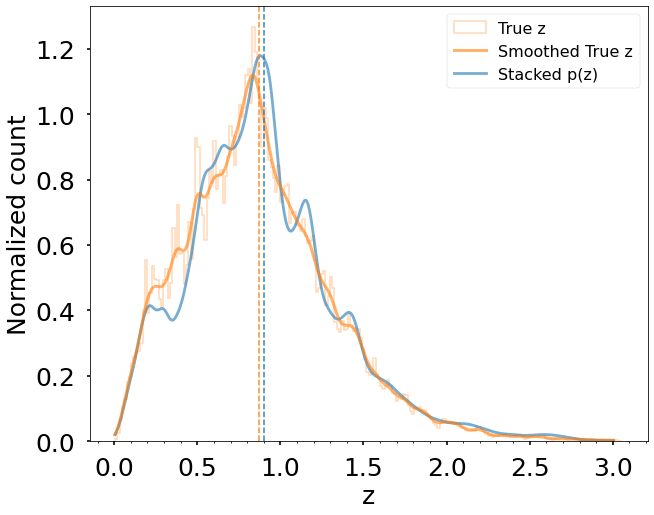

In [26]:
pzb.plot_pdf(num_truth=2, num_coadd=1, pz_type='z_mode', truth_pick='bright')

In [27]:
pzb.KS_PDF()

INFO:root:KS_PDF:load_redshifts: The redshift dataframes remained unchanged since no update was needed.
INFO:root:KS_PDF:stack_photoz: The stacked photoz remained unchanged since no update was needed.


0.03287476377171489

INFO:root:plot_pit:load_redshifts: The redshift dataframes remained unchanged since no update was needed.


INFO:root:plot_pit:calc_pits: New PIT values have been created.


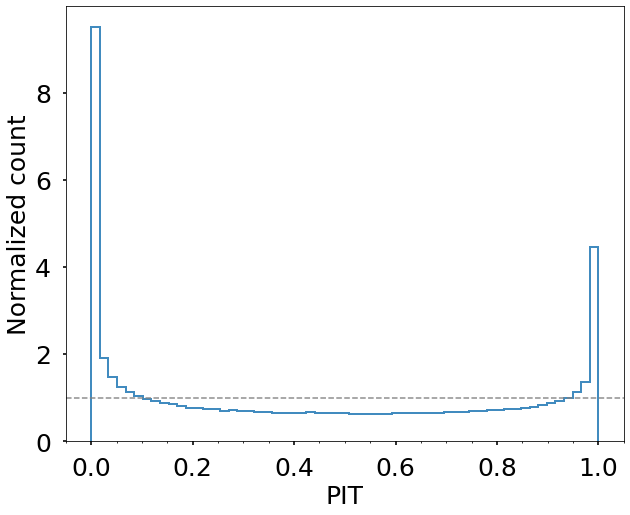

In [28]:
pzb.plot_pit(num_truth=2, num_coadd=1, pz_type='z_mode', truth_pick='bright')

In [29]:
pzb.KS_PITS()

INFO:root:KS_PITS:load_redshifts: The redshift dataframes remained unchanged since no update was needed.
INFO:root:KS_PITS:calc_pits: The PIT values remained unchanged since no update was needed.


KstestResult(statistic=0.17452853173176586, pvalue=0.0)

In [30]:
pzb.calc_cde_loss()

-0.07835894078016281

In [31]:
pzb.calc_3_moments()

{'first': 0.8990744, 'second': 1.0092297, 'third': 1.3401768}

## 2-1 faint

In [32]:
pzb.calc_point_statistics(num_truth=2, num_coadd=1, pz_type='z_mode', truth_pick='faint')


INFO:root:calc_point_statistics:load_redshifts: New redshift dataframes have been created.


(0.273662131643434, -0.12274171413435994, 0.6295924744852665)

INFO:root:plot_pdf:load_redshifts: The redshift dataframes remained unchanged since no update was needed.
INFO:root:plot_pdf:stack_photoz: New stacked photoz's have been created.
INFO:root:plot_pdf:kde_dask: Estimated the bandwidth of the kernel using the scott method to be 0.043.


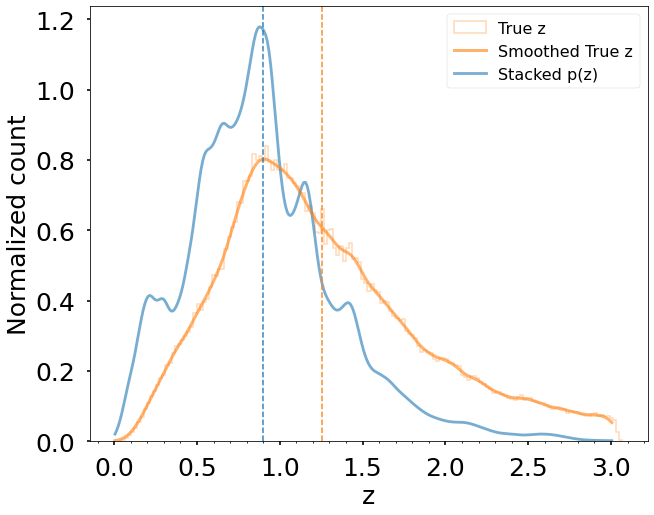

In [33]:
pzb.plot_pdf(num_truth=2, num_coadd=1, pz_type='z_mode', truth_pick='faint')

In [34]:
pzb.KS_PDF()

INFO:root:KS_PDF:load_redshifts: The redshift dataframes remained unchanged since no update was needed.
INFO:root:KS_PDF:stack_photoz: The stacked photoz remained unchanged since no update was needed.


ValueError: A value in x_new is below the interpolation range.

INFO:root:plot_pit:load_redshifts: The redshift dataframes remained unchanged since no update was needed.


INFO:root:plot_pit:calc_pits: New PIT values have been created.


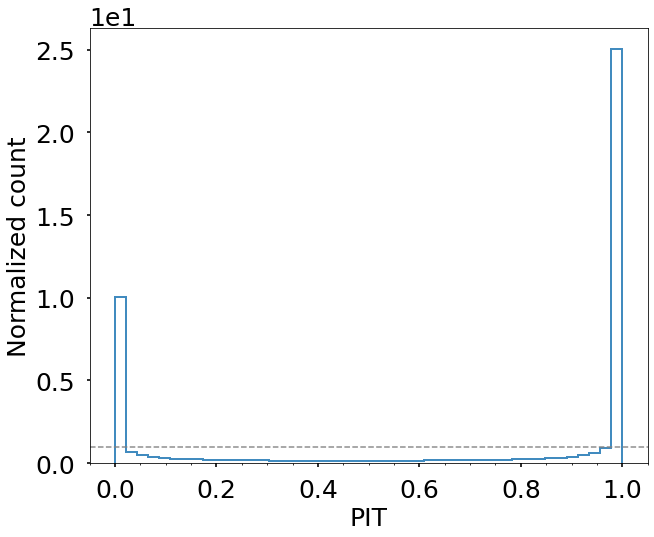

In [35]:
pzb.plot_pit(num_truth=2, num_coadd=1, pz_type='z_mode', truth_pick='faint')

In [36]:
pzb.KS_PITS()

INFO:root:KS_PITS:load_redshifts: The redshift dataframes remained unchanged since no update was needed.
INFO:root:KS_PITS:calc_pits: The PIT values remained unchanged since no update was needed.


KstestResult(statistic=0.5230357877203569, pvalue=0.0)

In [37]:
pzb.calc_cde_loss()

-0.01574105955660343

In [38]:
pzb.calc_3_moments()

{'first': 0.8990744, 'second': 1.0092297, 'third': 1.3401768}